## Compare Firebase Comm Logs with MongoDB Data

### Pull MongoDB data


In [1]:
import os
import datetime as dt
import pandas as pd
import csv

In [2]:
# add the 'src' directory as one where we can import modules
import sys
import pathlib # __file__ isn't recognized in Jupyter, so we need this to get the root path
path = pathlib.Path.cwd()
PROJ_ROOT = path.parent 
src_dir = str(PROJ_ROOT / 'src')
PROJ_ROOT = str(PROJ_ROOT)
sys.path.append(src_dir)
# from data import make_dataset

In [3]:
from data import user_df_setup

interim_data_file_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim",
                                 "full_users_df.pkl")
# users_df = pd.read_pickle(interim_data_file_path)
raw_data_file_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw",
                             "users_df.pkl")
raw_users_df = pd.read_pickle(raw_data_file_path)

all_users_df = user_df_setup.user_df_setup(raw_data_file_path, interim_data_file_path)

users_df = all_users_df
# raw_users_df
# raw_users_df[['username', 'timeCreated']].sort_values('timeCreated', ascending = False).head(20)
all_users_df.sort_values('date_created', ascending = False).head(5)
# all_users_df.index
# all_users_df.head(20)

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
davidt,2019-04-16,NaN,5cb60fc57aeafc0011cec7b2,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0
doyle coleman,2019-03-19,NaN,5c90fb30939ba200110ff237,0.0,1.0,3.0
driverseat,2019-03-19,NaN,5c90fa54939ba200110ff229,0.0,1.0,3.0
blonco,2019-03-19,NaN,5c90f9ea683da8001107a5af,0.0,1.0,3.0


In [4]:
current_users = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
user_ids = all_users_df['userId'].tolist()
print(len(user_ids))
# user_ids

136


## Set Usernames

In [5]:
usernames = current_users.index
usernames = ['pinky618','+vinny']

### Force-pulling Contacts data from MongoDB

In [6]:
from data import database_query

raw_data_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw")
# current_users_df = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
current_users_df = all_users_df[all_users_df.index.isin(usernames)]
user_ids = current_users_df['userId'].tolist()
database_query.make_raw_contacts_df(database_query.mongo_connect(),
                                   raw_data_path,
                                   user_ids)

In [7]:
current_users_df

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
+vinny,2018-11-14,NaN,5bec3a6b1dc2970010696def,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0


### Force-creating Contacts interim data

In [8]:
from data import contacts_df_setup
from data import user_df_setup

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
contacts_dict = {}

for username in usernames: 
    interim_contact_data_file_path = os.path.join(interim_data_path, 'contacts_df_' + username + '.pkl')
    if os.path.isfile(interim_contact_data_file_path):
        contacts_df = pd.read_pickle(interim_contact_data_file_path)
    else:
        current_users_df = user_df_setup.user_df_setup(os.path.join(raw_data_path, 'users_df.pkl'),
                                               os.path.join(interim_data_path, 'users_df.pkl'))
        contacts_df = contacts_df_setup.contacts_df_setup(username,
                                                          current_users_df,
                                                          raw_data_path,
                                                          interim_data_path)
    contacts_dict[username] = contacts_df

In [9]:
contacts_dict['+vinny'].head(10)

,score,relationship
_id,,
5bec3be00eb5fd0010495e3c,-1.000000,family
5bec3d440eb5fd0010495e54,-1.000000,risky
5bec3d551dc2970010696e09,-1.000000,risky
5bec3d570eb5fd0010495e55,4.274688,friend
5bec47481dc2970010696e19,-1.000000,none
5bec495c0eb5fd0010495e5c,-1.000000,none
5bec49730eb5fd0010495e5d,1.729452,other
5bec4aa00eb5fd0010495e5e,-1.000000,family
5bec4aae0eb5fd0010495e5f,-1.000000,risky


In [10]:
for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)
    contacts_dict[e]['risk_assignment'] = None
    
    contacts_dict[e].loc[((contacts_df['score'] < unrated_threshold)
                    & (contacts_df['relationship'] != 'risky')),'risk_assignment'] = 'unrated'
#     unrated = contacts_df['score'][(contacts_df['score'] < unrated_threshold)
#                                   & (contacts_df['relationship'] != 'risky')]
#     print(contacts_dict[e].head())
    contacts_dict[e].loc[((contacts_df['relationship'] == 'risky')
                        | ((contacts_df['score'] >= unrated_threshold)
                            & (contacts_df['score'] <= risky_threshold))), 'risk_assignment'] = 'risky'
#     risky = contacts_df['score'][(contacts_df['relationship'] == 'risky')
#                                 | ((contacts_df['score'] >= unrated_threshold)
#                                 & (contacts_df['score'] <= risky_threshold))]
    
    contacts_dict[e].loc[((contacts_df['score'] > risky_threshold)
                        & (contacts_df['score'] < supportive_threshold)
                        & (contacts_df['relationship'] != 'risky')), 'risk_assignment'] ='neutral'
#     neutral = contacts_df['score'][(contacts_df['score'] > risky_threshold)
#                                 & (contacts_df['score'] < supportive_threshold)]
    
    contacts_dict[e].loc[((contacts_df['score'] >= supportive_threshold)
                        & (contacts_df['relationship'] != 'risky')), 'risk_assignment'] ='supportive'
#     supportive = contacts_df['score'][(contacts_df['score'] >= supportive_threshold)]
# contacts_dict['+vinny'].head(10)

In [11]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
plt.tight_layout()

for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    unrated = contacts_df['score'][(contacts_df['risk_assignment'] == 'unrated')]
    risky = contacts_df['score'][(contacts_df['risk_assignment'] == 'risky')]
    neutral = contacts_df['score'][(contacts_df['risk_assignment'] == 'neutral')]
    supportive = contacts_df['score'][(contacts_df['risk_assignment'] == 'supportive')]
    
    axarr[count, 0].bar(supportive.index, supportive, 0.7, color = '#00cc00')
    axarr[count, 0].bar(neutral.index, neutral, 0.7, color = 'b')
    axarr[count, 0].bar(risky.index, risky, 0.7, color = '#ff6600')
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
    axarr[count, 0].set_title(e + ' - rated: ' + str(len(contacts_df) - len(unrated)) + ' unrated: ' + str(len(unrated)))
    
    # unrelated, pulling the counts
#     current_users_df.loc[e, 'unrated_contacts'] = len(unrated)
#     current_users_df.loc[e, 'risky_contacts'] = len(risky)
#     current_users_df.loc[e, 'neutral_contacts'] = len(neutral)
#     current_users_df.loc[e, 'supportive_contacts'] = len(supportive)
#     current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']
# current_users_df
# plt.show()

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
+vinny,2018-11-14,NaN,5bec3a6b1dc2970010696def,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0


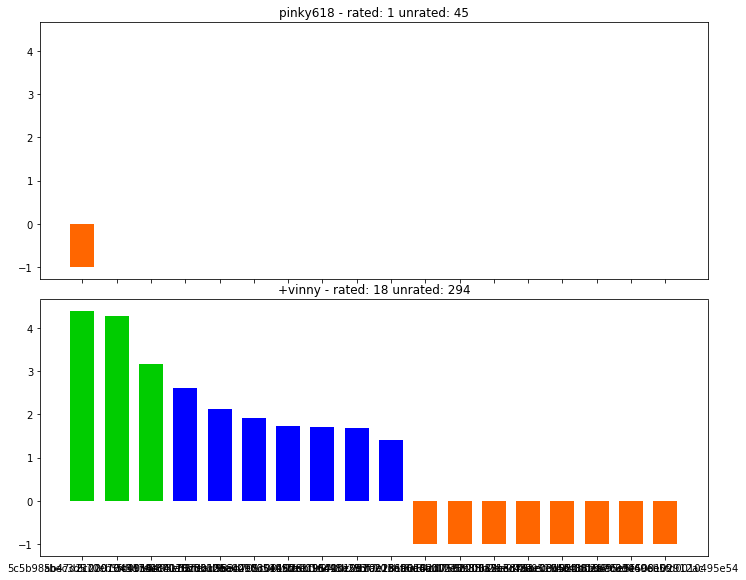

In [12]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
plt.tight_layout()

for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)
    unrated = contacts_df['score'][(contacts_df['score'] < unrated_threshold)
                                  & (contacts_df['relationship'] != 'risky')]
    risky = contacts_df['score'][(contacts_df['relationship'] == 'risky')
                                | ((contacts_df['score'] >= unrated_threshold)
                                & (contacts_df['score'] <= risky_threshold))]
    neutral = contacts_df['score'][(contacts_df['score'] > risky_threshold)
                                & (contacts_df['score'] < supportive_threshold)]
    supportive = contacts_df['score'][(contacts_df['score'] >= supportive_threshold)]
    
    axarr[count, 0].bar(supportive.index, supportive, 0.7, color = '#00cc00')
    axarr[count, 0].bar(neutral.index, neutral, 0.7, color = 'b')
    axarr[count, 0].bar(risky.index, risky, 0.7, color = '#ff6600')
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
    axarr[count, 0].set_title(e + ' - rated: ' + str(len(contacts_df) - len(unrated)) + ' unrated: ' + str(len(unrated)))
    
current_users_df.head()
# plt.show()

c:\users\vinny\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\vinny\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, 'Rated Contacts by Type')

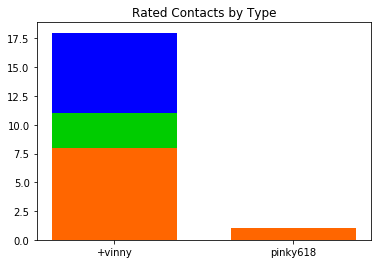

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
# plt.tight_layout()
fig = plt.figure()
ax = fig.add_subplot(111)

for count, e in enumerate(usernames):  
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    current_users_df.loc[e, 'unrated_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'unrated'])
    current_users_df.loc[e, 'risky_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'risky'])
    current_users_df.loc[e, 'neutral_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'neutral'])
    current_users_df.loc[e, 'supportive_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'supportive'])
    current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']

# for count, e in enumerate(usernames):     
ax.bar(current_users_df.index, current_users_df['risky_contacts'], 0.7, color = '#ff6600')
ax.bar(current_users_df.index, current_users_df['supportive_contacts'], 0.7, color = '#00cc00', bottom=current_users_df['risky_contacts'])
ax.bar(current_users_df.index, current_users_df['neutral_contacts'], 0.7, color = 'b', bottom=np.array(current_users_df['supportive_contacts'])+np.array(current_users_df['risky_contacts'])) 
# ax.bar(current_users_df.index, current_users_df['unrated_contacts'], 0.7, color = '#C0C0C0', bottom=current_users_df['neutral_contacts'])
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
ax.set_title('Rated Contacts by Type')

# plt.show()

### Force Creating Comm Data

In [14]:
from data import comm_df_analyses

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
comm_dict = {}
missing_comm_users = []
for username in usernames: 
#     if username not in current_users_df.index:
#         print(username + ' not in current_users_df')
#         missing_comm_users.append(username)
#         continue
        
#     interim_comm_data_file_path = os.path.join(interim_data_path, 'day_comm_log_df_' + username + '.pkl')
#     if os.path.isfile(interim_comm_data_file_path):
#         daily_comm_df = pd.read_pickle(interim_comm_data_file_path)
#         daily_comm_dict[username] = daily_comm_df
        
    interim_comm_data_file_path = os.path.join(interim_data_path, 'comm_log_df_' + username + '.pkl')
    if os.path.isfile(interim_comm_data_file_path):
        comm_df = pd.read_pickle(interim_comm_data_file_path)
    else:
        comm_df = comm_df_analyses.comm_df_setup(username,
                                              current_users_df,
                                              contacts_dict[username],
                                              raw_data_path,
                                              interim_data_path)
    comm_dict[username] = comm_df
# print(missing_comm_users)
# usernames = list(set(usernames) - set(missing_users))
# print(comm_dict['+vinny'].head())

#### Pulling daily comm

In [15]:
day_comm_dict = {}
for username in usernames: 
    day_comm_df = comm_df_analyses.time_bucket_comm(username,
                                                   users_df,
                                                   comm_dict[username],
                                                   interim_data_path,
                                                   'day')
#     day_comm_dict[username] = day_comm_df.sort_values('score', ascending = False)
# sort_index(axis=0, level=None, ascending=True, i
    day_comm_dict[username] = day_comm_df.sort_index(axis=0, ascending=False)
day_comm_dict['+vinny'][day_comm_dict['+vinny']['sms_sent_risky'] > 0].head(5)

,sms_sent_risky,sms_received_risky,phone_inbound_risky,phone_outbound_risky,sms_sent_neutral,sms_received_neutral,phone_inbound_neutral,phone_outbound_neutral,sms_sent_supportive,sms_received_supportive,...,phone_outbound_supportive,sms_sent_unrated,sms_received_unrated,phone_inbound_unrated,phone_outbound_unrated,total_comm,risky_comm,neutral_comm,supportive_comm,unrated_comm
2019-04-04,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,22.0,41.0,1.0,2.0,78.0,9.0,0.0,3.0,66.0
2019-03-30,5.0,6.0,0.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,...,0.0,4.0,20.0,5.0,4.0,57.0,11.0,13.0,0.0,33.0
2019-03-29,1.0,2.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,...,0.0,10.0,26.0,1.0,2.0,48.0,3.0,6.0,0.0,39.0
2019-03-28,2.0,5.0,1.0,1.0,3.0,8.0,0.0,0.0,5.0,7.0,...,0.0,30.0,32.0,12.0,5.0,111.0,9.0,11.0,12.0,79.0
2019-03-27,2.0,6.0,0.0,0.0,3.0,3.0,0.0,0.0,7.0,5.0,...,0.0,9.0,16.0,5.0,7.0,63.0,8.0,6.0,12.0,37.0


### Getting SQL data

In [16]:
from data import firebase_sql_queries

client = firebase_sql_queries.init_sql_connection()

In [17]:
day_firebase_texts_dict = {}
for username in usernames:
    if username == 'pinky618':
        username = 'Pinky618 '
    day_firebase_texts = firebase_sql_queries.get_day_text_events(client, username)
    day_firebase_texts.index = pd.to_datetime(day_firebase_texts['Date'])
    day_firebase_texts = day_firebase_texts.drop(columns='Date')
    
    day_firebase_texts_dict[username] = day_firebase_texts
day_firebase_texts_dict['+vinny'].head(15)

,in_sms,sent_sms,risky_sent_sms,risky_sent_notification,risky_in_sms,risky_in_notification,events
Date,,,,,,,
2019-04-19,4,0,2,2,8,0,16
2019-04-18,6,1,0,0,0,0,7
2019-04-16,19,6,0,0,0,0,25
2019-04-15,49,25,0,0,0,0,74
2019-04-14,49,21,0,0,0,0,70
2019-04-13,11,5,4,1,7,2,30
2019-04-12,14,8,0,0,0,0,22
2019-04-11,6,2,3,1,2,1,15
2019-04-10,80,35,0,0,0,0,115


In [18]:
firebase_texts_dict = {}
for username in usernames:
    if username == 'pinky618':
        username = 'Pinky618 '
    firebase_texts = firebase_sql_queries.get_text_events(client, username)
#     firebase_texts.index = pd.to_datetime(day_firebase_texts['Date'])
#     firebase_texts = day_firebase_texts.drop(columns='Date')
    
    firebase_texts_dict[username] = firebase_texts
firebase_texts_dict['+vinny'].head(15)

,Timestamp,in_sms,sent_sms,risky_sent_sms,risky_sent_notification,risky_in_sms,risky_in_notification,events
0,1555714938102487,0,0,0,1,0,0,1
1,1555714938091486,0,0,1,0,0,0,1
2,1555712455361293,0,0,0,1,0,0,1
3,1555712455356292,0,0,1,0,0,0,1
4,1555711298191291,0,0,0,0,1,0,1
5,1555711297520289,0,0,0,0,1,0,1
6,1555711297486286,0,0,0,0,1,0,1
7,1555711296934284,0,0,0,0,1,0,1
8,1555711240341942,0,0,0,0,1,0,1
9,1555711239323940,0,0,0,0,1,0,1


### Comparing MongoDB with Firebase

In [19]:
comparison_df = pd.DataFrame(np.nan, index=day_comm_dict['+vinny'].index, columns=[])
comparison_df['mongodb sent sms'] = (day_comm_dict['+vinny']['sms_sent_risky'] +
                                    day_comm_dict['+vinny']['sms_sent_neutral'] +
                                    day_comm_dict['+vinny']['sms_sent_supportive'] +
                                    day_comm_dict['+vinny']['sms_sent_unrated'])
comparison_df['firebase sent sms'] = (day_firebase_texts_dict['+vinny']['risky_sent_sms'] +
                             day_firebase_texts_dict['+vinny']['sent_sms'])
comparison_df['comparison sent sms'] = comparison_df['mongodb sent sms'] - comparison_df['firebase sent sms']
comparison_df

,mongodb sent sms,firebase sent sms,comparison sent sms
2019-04-26,0.0,NaN,NaN
2019-04-25,0.0,NaN,NaN
2019-04-24,0.0,NaN,NaN
2019-04-23,0.0,NaN,NaN
2019-04-22,0.0,NaN,NaN
2019-04-21,0.0,NaN,NaN
2019-04-20,0.0,NaN,NaN
2019-04-19,0.0,2.0,-2.0
2019-04-18,0.0,1.0,-1.0
2019-04-17,0.0,NaN,NaN


In [20]:
import numpy as np

for username in usernames: 
    if username in notification_dict.keys():
        notifications_df = notification_dict[username]
        current_users.loc[username, 'notifications'] = len(notifications_df.index)
    else:
        current_users.loc[username, 'notifications'] = 0

NameError: name 'notification_dict' is not defined